# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [133]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [134]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [135]:
data.head(5)

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### 1: What test is appropriate for this problem? Does CLT apply?

An appropriate test for this would be a z-test, because b/w and call back *should* be independent of each other. Although it is a Bernoulli distribution (call back yes/no), because n is sufficiently large and the CLT applies, it approaches a standard normal distribution and can use a z-test. The CLT does apply because 1) data is randomly sampled (ie assigning b or w on race when sent to employer) 2) values are independent 3) The sample size is sufficiently large.

### 2: What are the null and alternative hypothesis?
H0: P(w_call) = P(b_call)

Ha: P(w_call) != P(b_call)

alpha = 0.05

In [136]:
# "white" and "black" dfs
w = data[data.race=='w']
b = data[data.race=='b']

data.groupby(['race','call']).size().unstack()

call,0.0,1.0
race,,
b,2278,157
w,2200,235


In [137]:
w_call=w.call
w_called=w[w['call']==1] # df with all white callbacks

b_call=b.call
b_called=b[b['call']==1] # df with all black callbacks

p_w_call=len(w_called)/len(w_call) # % called/total white
p_b_call=len(b_called)/len(b_call) # % called/total black

print('P(w_call):', p_w_call)
print('P(b_call):', p_b_call)

P(w_call): 0.09650924024640657
P(b_call): 0.06447638603696099


Initially it looks like they have different probabilities of getting a call back, but is it actually significantly different?

## 3: Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches
### Frequentist Method

In [138]:
def SE(data1, data2):
    n1=len(data1)
    n2=len(data2)
    std1=np.std(data1)
    std2=np.std(data2)
    SE=np.sqrt(((std1**2)/n1) + ((std2**2)/n2))
    return SE

def MoE(SE, t=1.96): 
    MoE=t*SE # 1.96 t value chosen for 95%
    return MoE



In [139]:
SE = SE(w_call, b_call)
moe = MoE(SE, 1.96)
conf_int_w = (np.mean(w_call) - moe, np.mean(w_call) + moe)
conf_int_b = (np.mean(b_call) - moe, np.mean(b_call) + moe)

In [140]:
np.random.seed(175)
t, p = stats.ttest_rel(w_call, b_call)
print('t-stat=', t)
print('p-value from t test=', p)

print('Margin of Error:', moe)
print('Confidence Interval white:', conf_int_w)
print('Confidence Interval black:', conf_int_b)

t-stat= 5.081695355141535
p-value from t test= 4.0249580895084716e-07
Margin of Error: 0.015255284385449893
Confidence Interval white: (0.08125395618223429, 0.11176452495313406)
Confidence Interval black: (0.0492211013271737, 0.07973167009807348)


### Bootstrap Method

In [ ]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates"""
    # Initialize array of replicates
    bs_replicates=np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i]=bootstrap_replicate_1d(data, func)
    
    return bs_replicates

In [159]:
mean_prob = np.mean(data.call)

w_call_shifted = w_call - np.mean(w_call) + mean_prob
b_call_shifted = b_call - np.mean(b_call) + mean_prob

bs_replicates_w = draw_bs_reps(w_call_shifted, np.mean, 1000000)
bs_replicates_b = draw_bs_reps(b_call_shifted, np.mean, 1000000)

bs_replicates = bs_replicates_w - bs_replicates_b

p = np.sum(bs_replicates >= (p_w_call-p_b_call))/ len(bs_replicates)
conf_int = np.percentile(bs_replicates, (2.5, 97.5))
moe = conf_int[0] + mean_prob

print('p-value =', p)
print('Confidence interval:', conf_int)
print('Margin of Error:', moe)

p-value = 1.5e-05
Confidence interval: [-0.0151951   0.01519505]
Margin of Error: 0.06529771536588669


Because the p value is near 0 (very small), this means that the null hypthesis can be rejected, and there is a clear significant difference between the probability of getting called back for white vs black candidates.

### 4: Write a story describing the statistical significance in the context or the original problem.
Given the call back rate of resumes randomly assigned "white" or "black" sounding names, I determined that there was a statistically significant difference. This was done both with bootstrapping and frequentist methods, both of which returned very low p values and similar confidence intervals. The differences are a result of different methods (2 sample ttest vs bootstrap). Rejecting the null hypothesis due to low p values, it became clear that there was a difference in call back rates for black and white sounding names.

### 5: Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?
Not necessarily. There are many other factors that can play an important factor (education, years experience, etc). As can be seen from the correlation chart below, no specific column had a high correlation with race. Because race, sex, name are objects and don't have a value, they were removed. Correlation doesn't always show the most important variables, other methods would need to be used to see what truly is the most important factor.

In [204]:
data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\jason\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


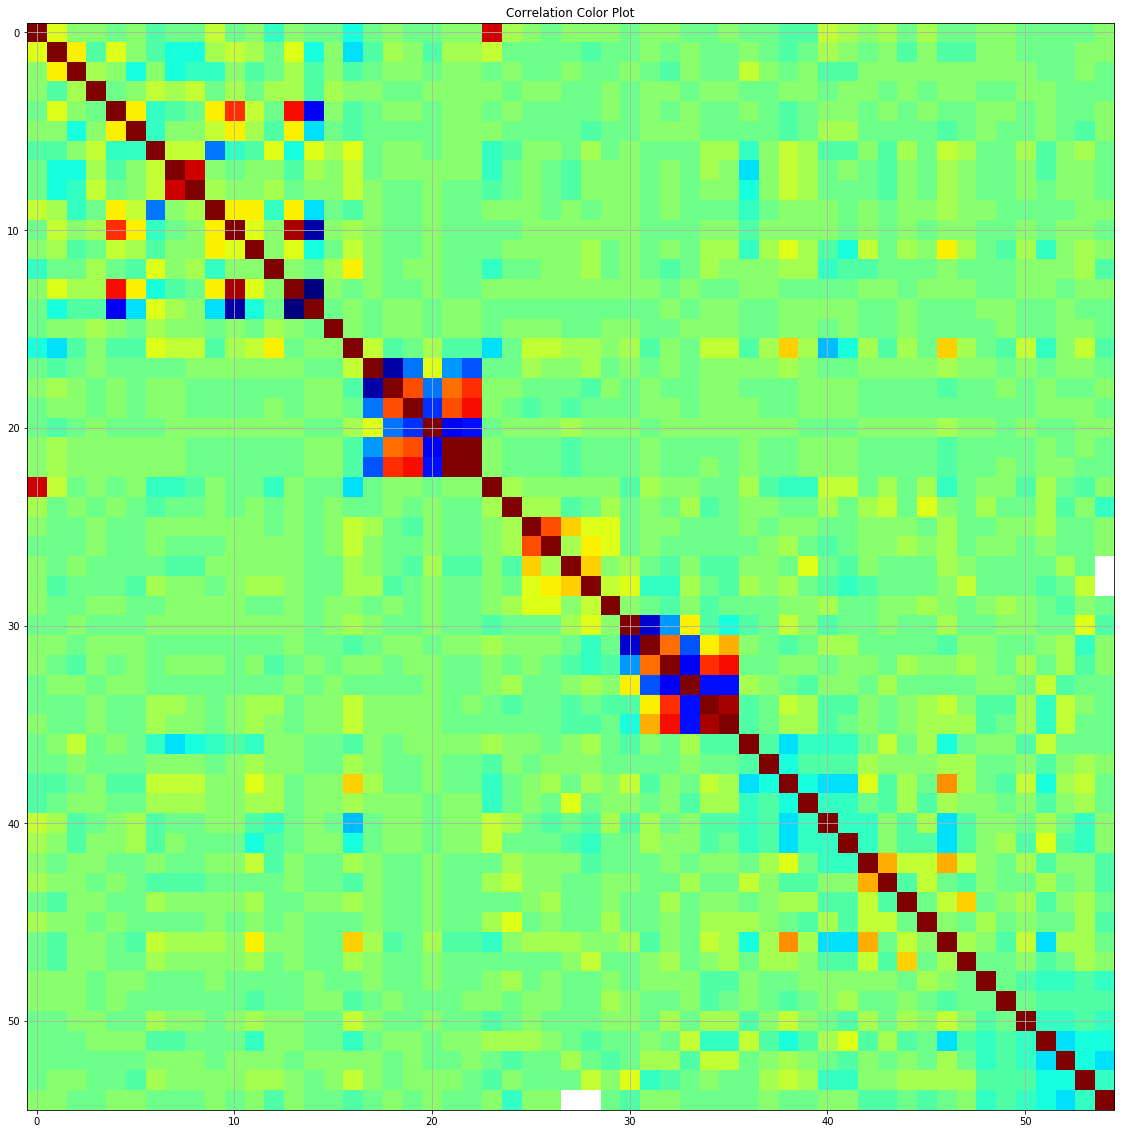

In [212]:
def correlation_matrix(df):
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Color Plot')
    plt.show()

correlation_matrix(data)